In [34]:
import requests
import pandas as pd
import numpy as np
import bt

API_KEY_FMP = 'SW7iWJC4lOhllC0XBJehTs2MY7lNyNvk'
tickers = [
    'AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO',
    'BA', 'BAC', 'BLK', 'BRK.B', 'C', 'CAT', 'CMCSA', 'COST', 'CRM', 'CSCO',
    'CVX', 'DIS', 'F', 'GE', 'GOOG', 'GOOGL', 'GS', 'HD', 'HON', 'IBM',
    'INTC', 'INTU', 'JNJ', 'JPM', 'KO', 'LLY', 'LMT', 'MA', 'MCD', 'MDT',
    'META', 'MKL', 'MRK', 'MS', 'MSFT', 'NEE', 'NFLX', 'NKE', 'NVDA', 'ORCL',
    'PEP', 'PFE', 'PG', 'PM', 'QCOM', 'SBUX', 'TSLA'
]

In [35]:
def get_price_history_fmp(ticker, api_key=API_KEY_FMP):
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey={api_key}&serietype=line"
    r = requests.get(url)
    data = r.json()
    
    if 'historical' not in data:
        print(f"[!] No se pudo obtener datos para {ticker}")
        return None

    df = pd.DataFrame(data['historical'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.sort_index()

    # Eliminar fechas duplicadas (nos quedamos con la última si hay repetidas)
    df = df[~df.index.duplicated(keep='last')]
    
    return df['close']


In [36]:
precios = pd.DataFrame()

for t in tickers:
    try:
        serie = get_price_history_fmp(t)
        if serie is not None:
            precios[t] = serie
    except Exception as e:
        print(f"[!] Error con {t}: {e}")


In [37]:
def get_fundamentals_fmp(ticker, api_key=API_KEY_FMP):
    fundamentals = {}

    # Perfil básico
    url_profile = f"https://financialmodelingprep.com/api/v3/profile/{ticker}?apikey={api_key}"
    r1 = requests.get(url_profile).json()

    if isinstance(r1, list) and len(r1) > 0:
        d = r1[0]
        fundamentals['ticker'] = ticker
        fundamentals['pe_ratio'] = pd.to_numeric(d.get('pe'), errors='coerce')
        fundamentals['pb_ratio'] = pd.to_numeric(d.get('priceToBookRatio'), errors='coerce')
        fundamentals['market_cap'] = d.get('mktCap')
    else:
        print(f"[!] No se pudo obtener perfil para {ticker}")
        return None

    # ROE desde ratios
    url_ratios = f"https://financialmodelingprep.com/api/v3/ratios-ttm/{ticker}?apikey={api_key}"
    r2 = requests.get(url_ratios).json()

    if isinstance(r2, list) and len(r2) > 0:
        fundamentals['roe'] = r2[0].get('returnOnEquityTTM')
    else:
        print(f"[!] No se pudo obtener ROE para {ticker}")
        fundamentals['roe'] = np.nan

    return fundamentals

# Obtener fundamentos para todos los tickers
fundamentals = []

for t in tickers:
    info = get_fundamentals_fmp(t)
    if info:
        fundamentals.append(info)

df_fundamentals = pd.DataFrame(fundamentals).set_index('ticker')


[!] No se pudo obtener perfil para BRK.B


In [38]:
# Retorno 12 meses (252 días) y volatilidad 3 meses (63 días)
if len(precios) >= 252:
    momentum_12m = precios.pct_change(252).iloc[-1]
else:
    momentum_12m = pd.Series(index=precios.columns, dtype='float64')

if len(precios) >= 63:
    volatilidad_3m = precios.pct_change().rolling(63).std().iloc[-1]
else:
    volatilidad_3m = pd.Series(index=precios.columns, dtype='float64')


C:\Users\Claudia\AppData\Local\Temp\ipykernel_10136\1501280967.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  momentum_12m = precios.pct_change(252).iloc[-1]
C:\Users\Claudia\AppData\Local\Temp\ipykernel_10136\1501280967.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  volatilidad_3m = precios.pct_change().rolling(63).std().iloc[-1]


In [39]:
df_factors = df_fundamentals.copy()
df_factors['momentum'] = momentum_12m
df_factors['volatility'] = volatilidad_3m
df_factors


,pe_ratio,pb_ratio,market_cap,roe,momentum,volatility
ticker,,,,,,
AAPL,NaN,NaN,3171915846000,1.513055,0.009021,0.031500
ABBV,NaN,NaN,337453056000,0.955853,0.114097,0.021178
ABT,NaN,NaN,233956284800,0.307582,0.295159,0.014086
ACN,NaN,NaN,188718667830,0.271104,-0.007267,0.020629
ADBE,NaN,NaN,160988526000,0.516534,-0.320076,0.020890
AMD,NaN,NaN,225033952743,0.038904,-0.142408,0.045879
AMGN,NaN,NaN,159903010280,0.929355,-0.048127,0.020705
AMZN,NaN,NaN,2337147378000,0.242567,0.139405,0.028562
ASML,NaN,NaN,313426561680,0.520812,-0.219789,0.030474


In [40]:
def calcular_score(df):
    df = df.copy()

    # Asegurar que los valores son numéricos
    for col in ['market_cap', 'momentum', 'roe', 'volatility']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # Ranking
    df['rank_size'] = df['market_cap'].rank(ascending=True)
    df['rank_volatility'] = df['volatility'].rank(ascending=True)
    df['rank_momentum'] = df['momentum'].rank(ascending=False)
    df['rank_roe'] = df['roe'].rank(ascending=False)

    # Score total sin pe_ratio
    df['score_total'] = (
        df['rank_size'] +
        df['rank_volatility'] +
        df['rank_momentum'] +
        df['rank_roe']
    )

    return df.sort_values('score_total')

df_scores = calcular_score(df_factors)
df_scores


,pe_ratio,pb_ratio,market_cap,roe,momentum,volatility,rank_size,rank_volatility,rank_momentum,rank_roe,score_total
ticker,,,,,,,,,,,
LMT,NaN,NaN,108293954160,0.834072,-0.009891,0.017866,5.0,12.0,40.0,8.0,65.0
MKL,NaN,NaN,24873618501,0.110180,0.242774,0.016798,1.0,11.0,18.0,43.0,73.0
ABT,NaN,NaN,233956284800,0.307582,0.295159,0.014086,28.0,5.0,15.0,26.0,74.0
MA,NaN,NaN,504527027400,1.876432,0.268168,0.020590,43.0,17.0,17.0,2.0,79.0
KO,NaN,NaN,304979050850,0.417059,0.113511,0.012379,35.0,1.0,31.0,16.0,83.0
HD,NaN,NaN,371008651200,2.361034,0.084621,0.016018,39.0,10.0,33.0,1.0,83.0
AMGN,NaN,NaN,159903010280,0.929355,-0.048127,0.020705,13.0,20.0,44.0,7.0,84.0
IBM,NaN,NaN,267666336000,0.213246,0.667187,0.020095,32.0,15.0,4.0,33.0,84.0
NFLX,NaN,NaN,545141428344,0.396123,0.899804,0.021499,44.0,24.0,1.0,17.0,86.0


In [57]:
# Seleccionar top N tickers con mejor score (menor es mejor)
N = 10

top_n_df = df_scores.nsmallest(N, 'score_total')
top_n_tickers = top_n_df.index.tolist()

print(f"Top {N} tickers seleccionados:")
print(top_n_tickers)


Top 10 tickers seleccionados:
['LMT', 'MKL', 'ABT', 'MA', 'KO', 'HD', 'AMGN', 'IBM', 'NFLX', 'MDT']


In [58]:
precios_backtest = precios[top_n_tickers].dropna()
# Crear estrategia con igual ponderación y rebalanceo mensual
estrategia = bt.Strategy('Factor Top N',
    [
        bt.algos.RunMonthly(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ]
)

# Crear backtest
bt_test = bt.Backtest(estrategia, precios_backtest)


In [59]:
def get_price_history_fmp(ticker, api_key=API_KEY_FMP):
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey={api_key}&serietype=line"
    r = requests.get(url)
    data = r.json()
    
    if 'historical' not in data:
        print(f"[!] No se pudo obtener datos para {ticker}")
        return None

    df = pd.DataFrame(data['historical'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.sort_index()
    return df['close']


In [60]:
spy = get_price_history_fmp('SPY')
precios_backtest['SPY'] = spy
precios_backtest = precios_backtest.dropna()


In [61]:
estrategia_spy = bt.Strategy('Benchmark SPY',
    [
        bt.algos.RunOnce(),
        bt.algos.SelectAll(),
        bt.algos.WeighEqually(),
        bt.algos.Rebalance()
    ]
)

bt_spy = bt.Backtest(estrategia_spy, precios_backtest[['SPY']])


100%|██████████| 2/2 [00:02<00:00,  1.31s/it]


Stat                 Factor Top N    Benchmark SPY
-------------------  --------------  ---------------
Start                2006-05-24      2006-05-24
End                  2025-07-02      2025-07-02
Risk-free rate       0.00%           0.00%

Total Return         1450.73%        385.26%
Daily Sharpe         0.89            0.52
Daily Sortino        1.42            0.81
CAGR                 15.43%          8.62%
Max Drawdown         -35.02%         -56.47%
Calmar Ratio         0.44            0.15

MTD                  -0.08%          0.32%
3m                   5.90%           9.80%
6m                   14.79%          6.02%
YTD                  14.42%          5.76%
1Y                   25.97%          12.90%
3Y (ann.)            18.31%          17.56%
5Y (ann.)            12.56%          14.70%
10Y (ann.)           12.96%          11.57%
Since Incep. (ann.)  15.43%          8.62%

Daily Sharpe         0.89            0.52
Daily Sortino        1.42            0.81
Daily Mean (ann.)   

<Axes: title={'center': 'Estrategia Factor Top N vs SPY'}>

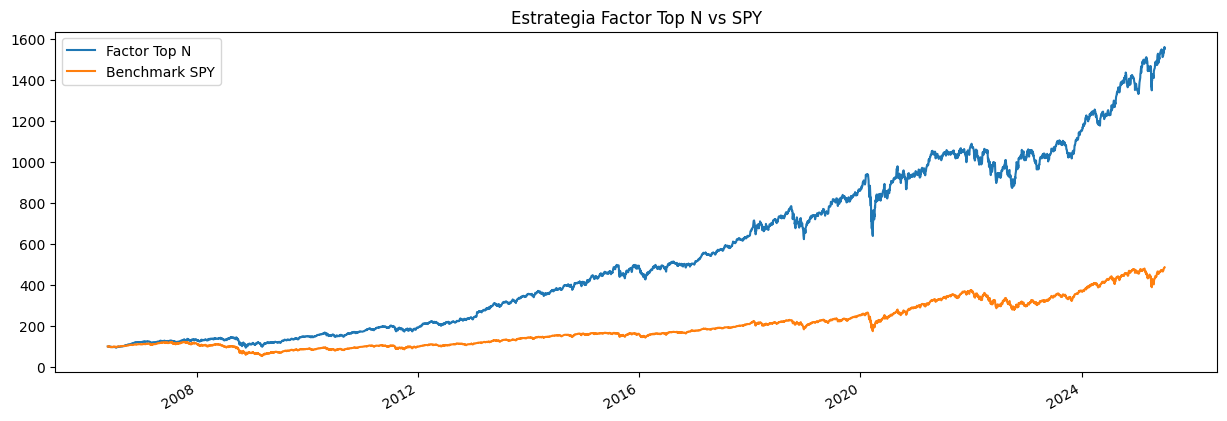

: 

In [ ]:
res = bt.run(bt_test, bt_spy)

# Mostrar métricas comparativas
res.display()

# Graficar comparación
res.plot(title='Estrategia Factor Top N vs SPY')
